In [197]:
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn import tree
import graphviz 
import pydotplus
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
import scipy.stats as st
import math
from sklearn.metrics import confusion_matrix, auc, RocCurveDisplay, roc_curve, roc_auc_score, multilabel_confusion_matrix,classification_report
import seaborn as sns
from sklearn import metrics
from sklearn.neural_network import MLPClassifier


from itertools import cycle

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Funcoes consideradas

In [223]:
def plot_variable_description_grah(df_data, title_complement='em todo conjunto de dados'):
    bars = []
    biggest = 0

    for attr in df_data.columns:
        table_values = df_data[attr].value_counts().to_dict()
        bars.append(table_values)
        table_size = len(table_values)
        if biggest < table_size:
            biggest = table_size

    def adapt_size(x:dict):
        dict_size = len(x)
        gap = biggest - dict_size
        for g in range(gap):
            x['fake'+str(g)]=0
        return x

    bars = list(map(adapt_size,bars))

    table_values_2 = np.array([])
    table_names = np.array([])
    for attr_dict in bars:
        table_values_2 = np.append(table_values_2,np.array(list(attr_dict.values())),axis=0)
        table_names = np.append(table_names,np.array(list(attr_dict.keys())),axis=0)
        

    table_values_2 = table_values_2.reshape(-1,biggest)
    table_names = table_names.reshape(-1,biggest)

    df_description = pd.DataFrame(table_values_2)
    df_description.index = df_data.columns

    ax = df_description.plot(kind='bar',stacked=True, edgecolor='black', legend=False, figsize=(20,6))
    for x,attr in enumerate(table_names):
        accum = 0
        for y,name in enumerate(attr):
            qtd = table_values_2[x][y]
            accum+=qtd
            if (qtd != 0):
                ax.annotate(name + ' : ' + str(int(qtd)),(x-.2,accum - table_values_2[x][y]/2))


    plt.title('Ocorrências de cada valor de variável {}'.format(title_complement),fontdict = {'fontsize':15,'fontweight':'bold'})
    plt.ylabel('Ocorrências',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.xlabel('Variável',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.xticks(
        rotation=0,
        horizontalalignment='center')


def plot_nested_pie_graph(df_data,sub_label):

    # Make data: I have 3 groups and 7 subgroups
    group_names=df_data['acceptability'].value_counts().to_frame(name='ocorrencias').reset_index().sort_values(by=['index'])['index']
    group_size=df_data['acceptability'].value_counts().to_frame(name='ocorrencias').reset_index().sort_values(by=['index'])['ocorrencias']

    df_subgroup = df_data[['acceptability',sub_label]].value_counts().to_frame(name='ocorrencias').reset_index().sort_values(by=['acceptability'])
    subgroup_names = df_subgroup[sub_label]
    subgroup_size = df_subgroup['ocorrencias']
    subgroup_aux = df_subgroup['acceptability']
    
    # Create colors
    a, b, c, d =[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
    
    # First Ring (outside)
    fig, ax = plt.subplots()
    ax.axis('equal')
    mypie, _ = ax.pie(group_size, radius=2, labels=group_names, colors=[a(0.9), b(0.9), c(0.9), d(0.9)] )
    plt.setp( mypie, width=0.7, edgecolor='white')
    
    # Second Ring (Inside)
    color_dict = {}
    teste_2 = [a, b, c, d]
    for x_id, x in enumerate(subgroup_aux.unique()):
        color_dict[x]=[teste_2[x_id],0.4]
    color_dict

    color_list = []
    intens_color = {

    }
    for x in list(subgroup_aux):
        color_gradient = color_dict[x][0]
        color_intensity = color_dict[x][1]
        color_dict[x][1]-=.1
        color_list.append(color_gradient(color_intensity))

    # mypie2, _ = ax.pie(subgroup_size, radius=2-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), c(0.6), c(0.5), c(0.4), c(0.3), c(0.2)])
    mypie2, _ = ax.pie(subgroup_size, radius=2-0.7, labels=subgroup_names, labeldistance=0.7, colors=color_list)
    plt.setp( mypie2, width=0.7, edgecolor='white')
    plt.margins(0,0)

    # show it
    plt.show()


# Desvio padrao para a diferenca entre os erros de acordo com os slides de aula
def desvio_padrao_cv(npScore):
    def quadrado(a):
        return math.pow(a,2)
    media_diferenca = npScore.mean()
    k = npScore.shape[0]
    return math.pow(np.vectorize(quadrado)(npScore - media_diferenca).sum()/(k*(k-1)),.5)

# Compara dois modelos de ML
def comparativo_modelos(x_train_val,y_train_val,modelo1,modelo2,qtd_folders=10,nome_modelo1='modelo 1',nome_modelo2='modelo 2',scoring=None):
    nomes_indicadores_grafico = {
        None:'Acuracidade',
        'precision_macro':'Precisao',
        'recall_macro':'Recall',
        'f1_macro':'F1 Score',
    }
    
    # Rodo qtd_folders-fold cross validation
    # cv: quantidade de folds
    
    valorCategoricos = ['acceptability_acc','acceptability_good', 'acceptability_unacc', 'acceptability_vgood']
    y_train_val_categorico = np.array([np.array(valorCategoricos[x.argmax()]) for x in y_train_val])
    scores_modelo1 = cross_val_score(modelo1,x_train_val,y_train_val_categorico,cv=StratifiedKFold(n_splits=qtd_folders), scoring=scoring)
    scores_modelo2 = cross_val_score(modelo2,x_train_val,y_train_val_categorico,cv=StratifiedKFold(n_splits=qtd_folders), scoring=scoring)
    print('%s Média %s: %.2f (+/- %.2f)'%((scoring or 'Acuracidade'),nome_modelo1,scores_modelo1.mean(),st.t.ppf(.95,qtd_folders-1)*scores_modelo1.std(ddof=1)))
    print('%s Média %s: %.2f (+/- %.2f)'%((scoring or 'Acuracidade'),nome_modelo2,scores_modelo2.mean(),st.t.ppf(.95,qtd_folders-1)*scores_modelo2.std(ddof=1)))

    # diferenca = Acuracidade Média Modelo 1 - Acuracidade Média Modelo 1
    # H0: diferenca = 0
    # H0: diferenca < 0
    # alpha = 0.05
    # 1 - alpha = 0.95
    # t (n-1,alpha) = t (qtd_folders-1,0.05) = 1,883 (one-tailed test)

    media_diferenca = (scores_modelo1 - scores_modelo2).mean()
    desvio_diferenca = (scores_modelo1 - scores_modelo2).std(ddof=1)

    t_calculado = media_diferenca/(desvio_diferenca/math.sqrt(qtd_folders))
    print('Media das diferenças: %.2f'%(media_diferenca))
    print('Desvio Padrao das diferenças: %.2f'%(desvio_diferenca))
    print('t (%d-2): %.2f'%(2*qtd_folders,t_calculado))
    print('- t (%d-2,0.05): %.2f' % (2*qtd_folders,-st.t.ppf(.95,2*qtd_folders-2)))

    nome_score = scoring if scoring != None else 'acuracidade'

    # Se t calculado for menor do que o t tabelado de teste entao refeito H0 e portanto a media de acuracidade da arvore de decisao e maior!
    if (t_calculado < -st.t.ppf(.95,2*qtd_folders-2)):
        print('Como t ({}-2) < - t ({}-2,0.05) entao rejeito H0 com 5% de significancia. {} media da {} e maior'.format(2*qtd_folders,2*qtd_folders,nomes_indicadores_grafico[scoring],nome_modelo2))
    else:        
        print('Nao se pode afirmar que a {} Media {} nao e maior'.format(nomes_indicadores_grafico[scoring],nome_modelo2))

    df_boxplot = pd.DataFrame(scores_modelo1,columns=['Score'])
    df_boxplot['Modelo']=nome_modelo1
    df_boxplot_aux = pd.DataFrame(scores_modelo2,columns=['Score'])
    df_boxplot_aux['Modelo']=nome_modelo2
    df_boxplot = pd.concat([df_boxplot,df_boxplot_aux]).reset_index(drop=True)
    fig = plt.figure(figsize=(10, 7), dpi=80)    
    ax = sns.boxplot(x="Modelo", y="Score", data=df_boxplot)
    plt.ylabel(nomes_indicadores_grafico[scoring])
    plt.title("Boxplot - " + nomes_indicadores_grafico[scoring] + " de cada modelo")

# Plota a matriz de confusao
def plotar_matriz_confusao(conf_mat_cv_MultinomialNB,display_labels,parte_titulo=None):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_cv_MultinomialNB, display_labels = display_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)
    plt.title('Matriz de confusao - {}\n'.format(parte_titulo),fontdict = {'fontsize':15,'fontweight':'bold'})
    plt.ylabel('Valor Real',fontdict = {'fontsize':15,'fontweight':'bold'})
    plt.xlabel('Valor Previsto',fontdict = {'fontsize':15,'fontweight':'bold'})
    plt.show()

In [90]:
nomes_indicadores_grafico = {
        None:'Acuracidade',
        'precision_macro':'Precisao',
        'recall_macro':'Recall',
        'f1_macro':'F1 Score',
    }
nomes_indicadores_grafico[None]

'Acuracidade'

# Importacao dos dados

In [91]:
# Import data and set the column names
data_description = {
    'buying':'buying price',
    'maint':'price of the maintenance',
    'doors':'number of doors',
    'persons':'capacity in terms of persons to carry',
    'lug_boot':'the size of luggage boot',
    'safety':'estimated safety of the car',
    'acceptability': 'car acceptability'
}
headers = data_description.keys()

path = 'input/car.data'
df_data = pd.read_csv(path,header=None)
df_data.columns = headers
df_data.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


# Descrição dos dados


In [92]:
# Number of instances and number of attributes
df_data.shape

(1728, 7)

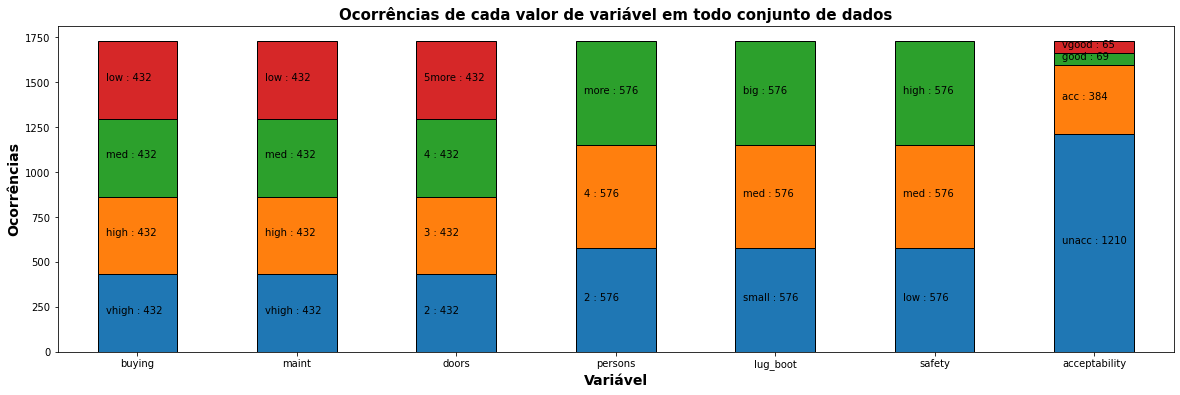

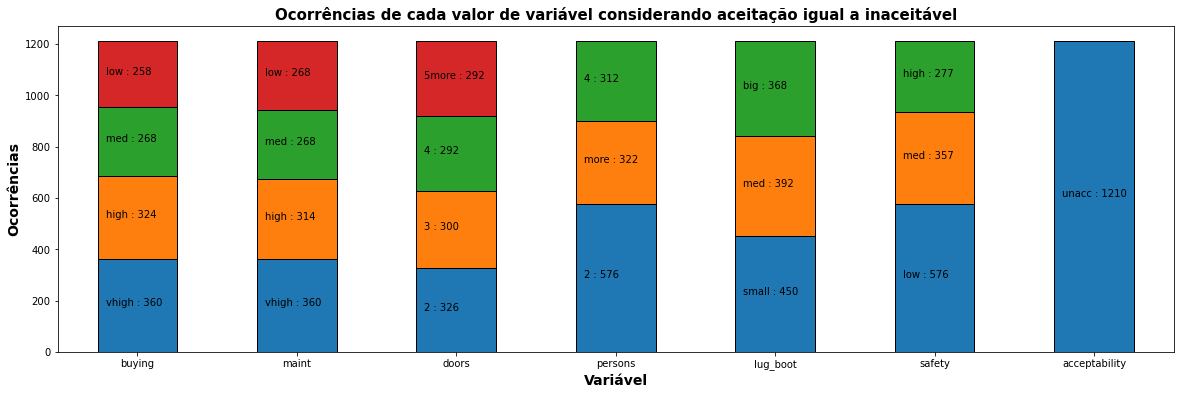

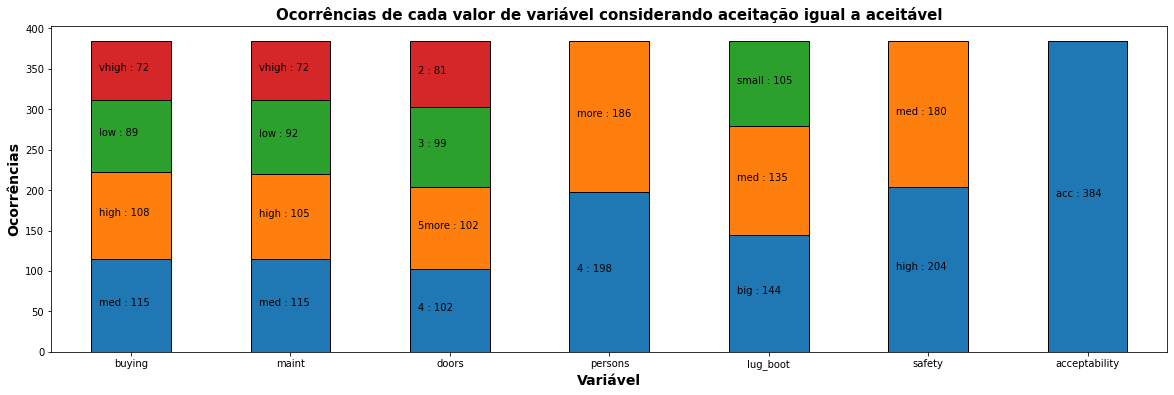

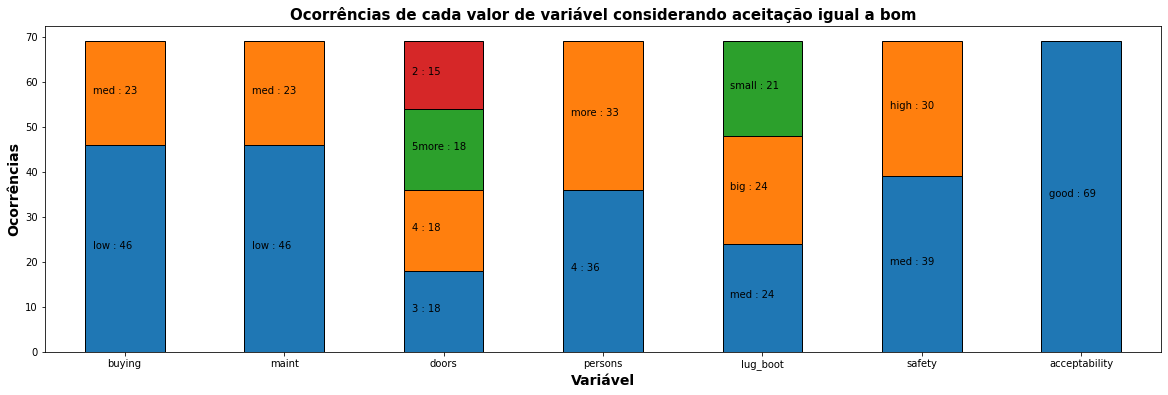

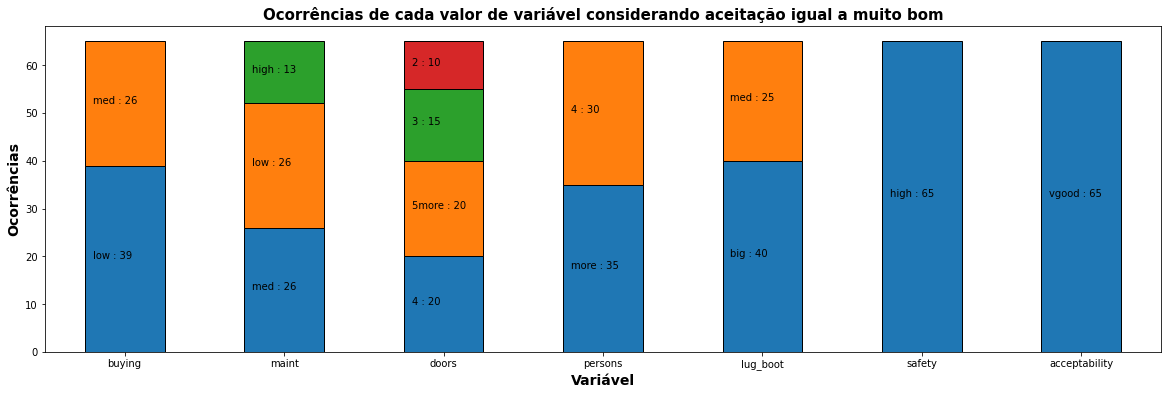

In [93]:
#plot graph of the desciption of every variable
plot_variable_description_grah(df_data)
plot_variable_description_grah(df_data[df_data['acceptability'] == 'unacc'],'considerando aceitação igual a inaceitável')
plot_variable_description_grah(df_data[df_data['acceptability'] == 'acc'],'considerando aceitação igual a aceitável')
plot_variable_description_grah(df_data[df_data['acceptability'] == 'good'],'considerando aceitação igual a bom')
plot_variable_description_grah(df_data[df_data['acceptability'] == 'vgood'],'considerando aceitação igual a muito bom')

# Preparacao dos dados

In [95]:
categorical_order = [
    ['low','med','high','vhigh'],
    ['low','med','high','vhigh'],
    ['2', '3', '4', '5more'],
    ['2', '4', 'more'],
    ['small', 'med', 'big'],
    ['low', 'med', 'high'],
    ['unacc', 'acc', 'good', 'vgood'],
]
for x in df_data.columns:
    print(df_data[x].unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['2' '3' '4' '5more']
['2' '4' 'more']
['small' 'med' 'big']
['low' 'med' 'high']
['unacc' 'acc' 'vgood' 'good']


In [96]:
df_data.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [97]:
enc = OrdinalEncoder(categories=categorical_order)
enc.fit(df_data)
df_data_ordinal_encoded = enc.transform(df_data)
df_data_ordinal_encoded

array([[3., 3., 0., ..., 0., 0., 0.],
       [3., 3., 0., ..., 0., 1., 0.],
       [3., 3., 0., ..., 0., 2., 0.],
       ...,
       [0., 0., 3., ..., 2., 0., 0.],
       [0., 0., 3., ..., 2., 1., 2.],
       [0., 0., 3., ..., 2., 2., 3.]])

In [98]:
enc_onehot = OneHotEncoder()
enc_onehot.fit(df_data)
df_data_ordinal_encoded_onehot = enc_onehot.transform(df_data).toarray()
df_data_ordinal_encoded_onehot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [99]:
# print(df_data_ordinal_encoded_onehot[0])
enc_onehot.get_feature_names_out()

array(['buying_high', 'buying_low', 'buying_med', 'buying_vhigh',
       'maint_high', 'maint_low', 'maint_med', 'maint_vhigh', 'doors_2',
       'doors_3', 'doors_4', 'doors_5more', 'persons_2', 'persons_4',
       'persons_more', 'lug_boot_big', 'lug_boot_med', 'lug_boot_small',
       'safety_high', 'safety_low', 'safety_med', 'acceptability_acc',
       'acceptability_good', 'acceptability_unacc', 'acceptability_vgood'],
      dtype=object)

In [100]:
print(df_data_ordinal_encoded_onehot.shape)
print(df_data_ordinal_encoded_onehot[:,-4:].shape)
print(df_data_ordinal_encoded_onehot[:,:-4].shape)

(1728, 25)
(1728, 4)
(1728, 21)


## Separar 20% para teste. Dos 80% restantes, separar 30% para validação e 70% para treinamento 

In [101]:
# Separar 20% dos dados para teste
# x_train_val, x_test, y_train_val, y_test = train_test_split(df_data_ordinal_encoded[:,:-1], df_data_ordinal_encoded[:,-1], test_size=0.20, random_state=1)
x_train_val, x_test, y_train_val, y_test = train_test_split(df_data_ordinal_encoded_onehot[:,:-4], df_data_ordinal_encoded_onehot[:,-4:], test_size=0.20, random_state=1)

# Modelagem - criar Arvore Decisao e MLP, gridsearch

In [173]:
model_DecisionTree = tree.DecisionTreeClassifier(random_state=1)
model_MLP = MLPClassifier(random_state=1, max_iter=300)

In [180]:
parametros = {
        'criterion':['gini','entropy'],
        'class_weight':['balanced',None],
        'max_depth':[d for d in range(3,22,3)]
    }
grid_DecisionTree = GridSearchCV(estimator = model_DecisionTree,
                    param_grid = parametros,
                    scoring = 'f1_macro',
                    cv = 10)

# Treinando o grid_DecisionTree
grid_DecisionTree.fit(x_train_val, y_train_val)

/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` paramet

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=15, random_state=1),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 12, 15, 18, 21]},
             scoring='f1_macro')

In [182]:
parametros = {
    'hidden_layer_sizes': [(100,),(50,50),(50,100), (100,50), (100,100), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}
grid_MLP = GridSearchCV(estimator = model_MLP,
                    param_grid = parametros,
                    scoring = 'f1_macro',
                    n_jobs=-1,
                    cv = 10)

# Treinando o grid_DecisionTree
grid_MLP.fit(x_train_val, y_train_val)

/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yamada/miniforge3/envs/.aprendizado_estatistico/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: M

GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=300, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(100,), (50, 50), (50, 100),
                                                (100, 50), (100, 100),
                                                (50, 100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='f1_macro')

In [185]:
print(grid_DecisionTree.best_params_)
print(grid_MLP.best_params_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15}
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [186]:
print(grid_DecisionTree.best_score_)
print(grid_MLP.best_score_)

0.9116515830947567
0.9694783468018665


In [188]:
model_DecisionTree = tree.DecisionTreeClassifier(random_state=1,**grid_DecisionTree.best_params_)
model_MLP = MLPClassifier(random_state=1, max_iter=300,**grid_MLP.best_params_)

In [194]:
print(model_DecisionTree.get_params())
print(model_MLP.get_params())

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 300, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


## Quero verificar via teste de hipótese se a média dos indicadores do MLP sao maiores do que os da árvore de decisão considerando 5% de significancia

Acuracidade Média DecisionTree: 0.97 (+/- 0.02)
Acuracidade Média MLP: 1.00 (+/- 0.01)
Media das diferenças: -0.03
Desvio Padrao das diferenças: 0.01
t (20-2): -6.89
- t (20-2,0.05): -1.73
Como t (20-2) < - t (20-2,0.05) entao rejeito H0 com 5% de significancia. Acuracidade media da MLP e maior
precision_macro Média DecisionTree: 0.95 (+/- 0.08)
precision_macro Média MLP: 0.99 (+/- 0.05)
Media das diferenças: -0.04
Desvio Padrao das diferenças: 0.04
t (20-2): -3.19
- t (20-2,0.05): -1.73
Como t (20-2) < - t (20-2,0.05) entao rejeito H0 com 5% de significancia. Precisao media da MLP e maior
recall_macro Média DecisionTree: 0.94 (+/- 0.05)
recall_macro Média MLP: 1.00 (+/- 0.01)
Media das diferenças: -0.06
Desvio Padrao das diferenças: 0.03
t (20-2): -6.10
- t (20-2,0.05): -1.73
Como t (20-2) < - t (20-2,0.05) entao rejeito H0 com 5% de significancia. Recall media da MLP e maior
f1_macro Média DecisionTree: 0.94 (+/- 0.04)
f1_macro Média MLP: 0.99 (+/- 0.03)
Media das diferenças: -0.05
D

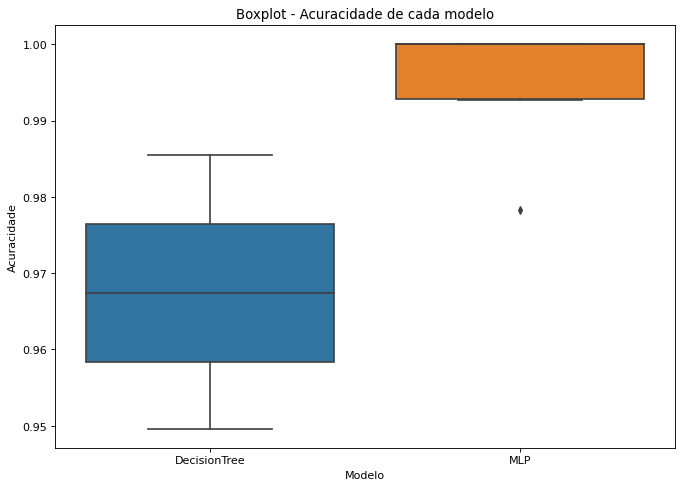

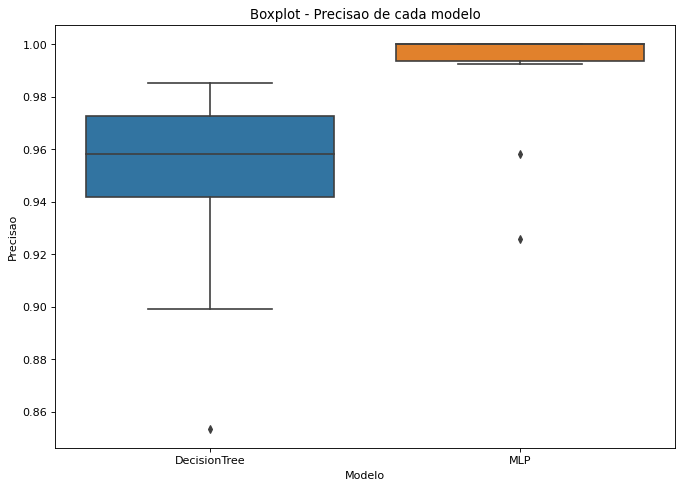

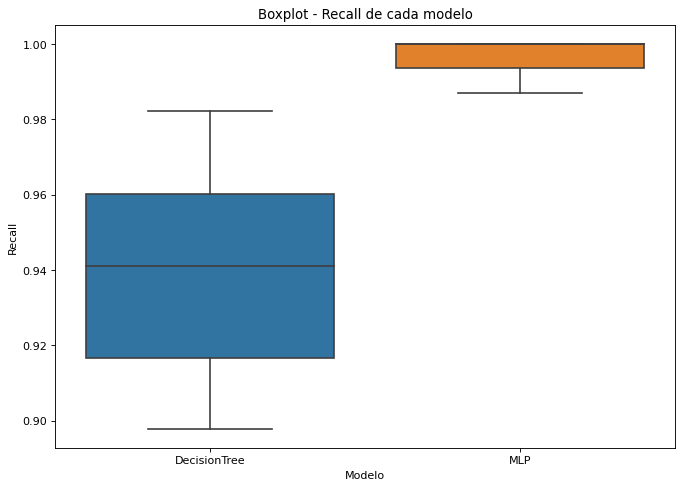

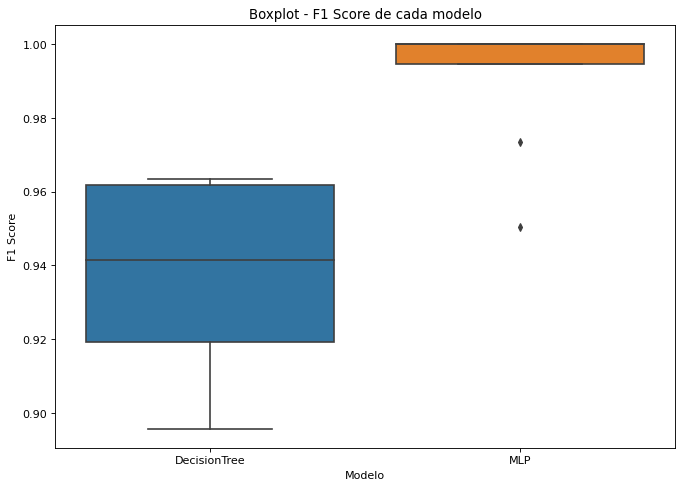

In [214]:
# Compara dois modelos de ML MultinomialNB e DecisionTree
comparativo_modelos(
    x_train_val=x_train_val,
    y_train_val=y_train_val,
    modelo1=model_DecisionTree,
    modelo2=model_MLP,
    qtd_folders=10,
    nome_modelo1='DecisionTree',
    nome_modelo2='MLP')

# Compara dois modelos de DecisionTree e MLP pela precisao media
comparativo_modelos(
    x_train_val=x_train_val,
    y_train_val=y_train_val,
    modelo1=model_DecisionTree,
    modelo2=model_MLP,
    qtd_folders=10,
    nome_modelo1='DecisionTree',
    nome_modelo2='MLP',
    scoring='precision_macro')

# Compara dois modelos de DecisionTree e MLP pelo recall media
comparativo_modelos(
    x_train_val=x_train_val,
    y_train_val=y_train_val,
    modelo1=model_DecisionTree,
    modelo2=model_MLP,
    qtd_folders=10,
    nome_modelo1='DecisionTree',
    nome_modelo2='MLP',
    scoring='recall_macro')

# Compara dois modelos de DecisionTree e MLP pelo f1 score medio
comparativo_modelos(
    x_train_val=x_train_val,
    y_train_val=y_train_val,
    modelo1=model_DecisionTree,
    modelo2=model_MLP,
    qtd_folders=10,
    nome_modelo1='DecisionTree',
    nome_modelo2='MLP',
    scoring='f1_macro')

# Usar o modelo MLP na base de testes

In [216]:
model_MLP.fit(x_train_val, y_train_val)
y_chapeu = model_MLP.predict(x_test)
acertos = [x.all() for x in (y_chapeu == y_test)]

print('Acuracidade {}'.format(sum(acertos)/len(acertos)))

Acuracidade 0.9913294797687862


In [217]:
print('Acuracidade {0:.3g}'.format(sum(acertos)/len(acertos)))
estatisticas_comparacao = classification_report(y_test,y_chapeu)
print(estatisticas_comparacao)

Acuracidade 0.991
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        59
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00       260
           3       1.00      1.00      1.00        13

   micro avg       0.99      1.00      0.99       346
   macro avg       0.98      1.00      0.99       346
weighted avg       0.99      1.00      0.99       346
 samples avg       0.99      1.00      1.00       346



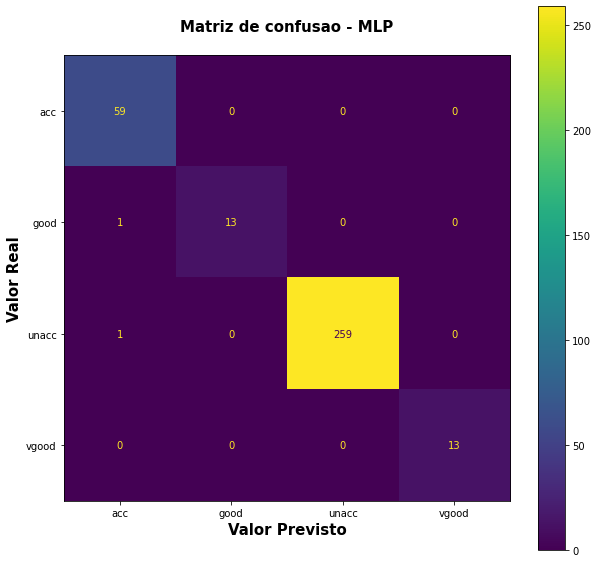

In [224]:
valorCategoricos = ['acc','good', 'unacc', 'vgood']
y_chapeu_categorico = np.array([np.array(valorCategoricos[x.argmax()]) for x in y_chapeu])
y_test_categorico = np.array([np.array(valorCategoricos[x.argmax()]) for x in y_test])
conf_mat_cv_MLP = confusion_matrix(y_test_categorico, y_chapeu_categorico)
plotar_matriz_confusao(conf_mat_cv_MLP,display_labels=valorCategoricos,parte_titulo='MLP')